In [16]:
# Import libraries
from selenium import webdriver
from io import BytesIO
import matplotlib.pyplot as plt
import cv2, requests, numpy as np
import random
from joblib import load

In [50]:
# Init webdriver
# If you are using firefox
driver = webdriver.Firefox(executable_path=r'../drivers/linux/geckodriver')

## Downloading captcha image

In [51]:
# Define URL
url = 'https://nfce.set.rn.gov.br/portalDFE/NFCe/ConsultaNFCe.aspx'

In [108]:
driver.get(url)
captcha = driver.find_element_by_id("img_captcha")
loc = captcha.location
size = captcha.size

fullPage = driver.get_screenshot_as_png()
img_stream = BytesIO(fullPage)
img = cv2.imdecode(np.frombuffer(img_stream.read(), np.uint8), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[ int(loc['y']): int(loc['y'] + size['height']) , int(loc['x']): int(loc['x'] + size['width']) ]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

<function matplotlib.pyplot.show(*args, **kw)>

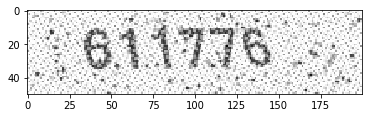

In [109]:
plt.imshow(gray, cmap='gray')
plt.show

## Image processing stage

<function matplotlib.pyplot.show(*args, **kw)>

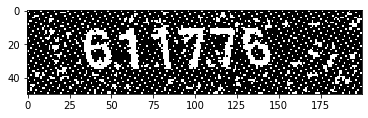

In [110]:
binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,75,10)
plt.imshow(binary, cmap='gray')
plt.show

Text(0.5, -0.1, 'Final result')

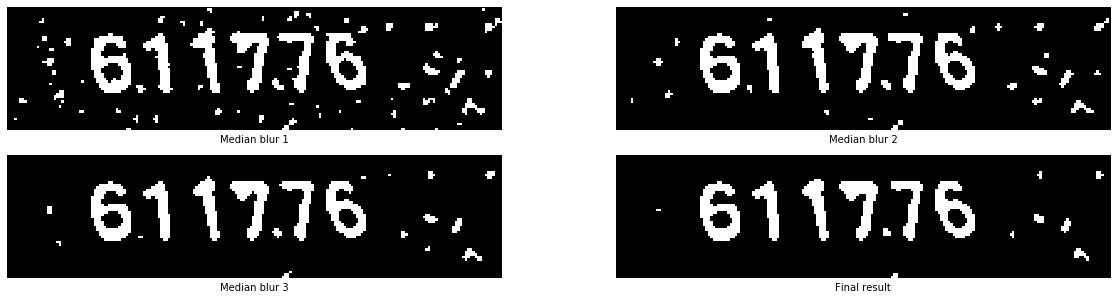

In [111]:
plt.figure(figsize=(20,5))
filtered = cv2.medianBlur(binary, 3)
ax1 = plt.subplot(221)
ax1.imshow(filtered, cmap='gray')

filtered = cv2.medianBlur(filtered, 3)
ax2 = plt.subplot(222)
ax2.imshow(filtered, cmap='gray')

filtered = cv2.medianBlur(filtered, 3)
ax3 = plt.subplot(223)
ax3.imshow(filtered, cmap='gray')

filtered = cv2.medianBlur(filtered, 3)
ax4 = plt.subplot(224)
ax4.imshow(filtered, cmap='gray')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

ax1.text(0.5,-0.1, "Median blur 1", ha="center", transform=ax1.transAxes)
ax2.text(0.5,-0.1, "Median blur 2", ha="center", transform=ax2.transAxes)
ax3.text(0.5,-0.1, "Median blur 3", ha="center", transform=ax3.transAxes)
ax4.text(0.5,-0.1, "Final result", ha="center", transform=ax4.transAxes)

## Finding contours

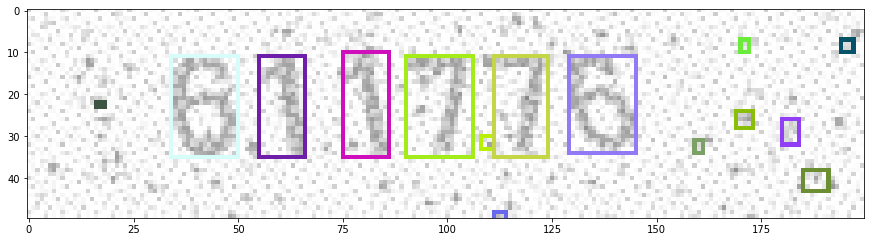

In [112]:
SZ_W = 15
SZ_H = 20

_, contours, _ = cv2.findContours(filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_cp = img.copy()

for c in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[c])
    cv2.rectangle(img_cp,(x,y),(x+w,y+h),
                 (random.randint(0, 255), 
                  random.randint(0, 255), 
                  random.randint(0, 255)),1)

plt.figure(figsize=(15,10))
plt.imshow(img_cp)
plt.show()

## Sorting by contour size and position

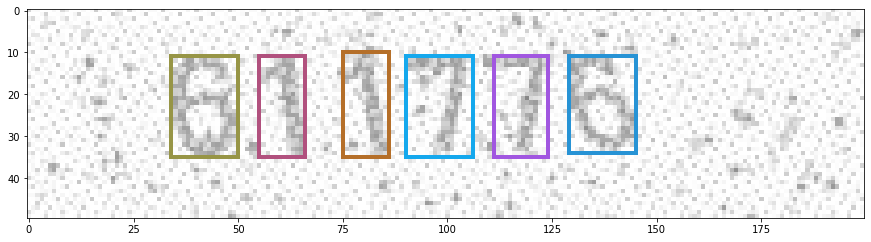

In [113]:
def top_left(c):
    x,y,_,_ = cv2.boundingRect(c)
    return (x,y)

contours.sort(key=len,reverse=True)
contours = contours[:min(6, len(contours))]
contours.sort(key=top_left)

img_cp = img.copy()

for c in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[c])
    cv2.rectangle(img_cp,(x,y),(x+w,y+h),(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)),1)

plt.figure(figsize=(15,10))
plt.imshow(img_cp)
plt.show()

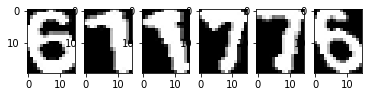

In [114]:
fig_chars = plt.figure()

for c in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[c])
    crop = np.zeros(filtered.shape, dtype=np.uint8)
    cv2.drawContours(crop, contours, c, 255, -1)
    crop = cv2.bitwise_and(crop, filtered)
    crop = crop[y:y+h, x:x+w]

    crop = cv2.resize(crop, (SZ_W, SZ_H), interpolation = cv2.INTER_CUBIC)
    fig_chars.add_subplot(1, 6, c+1)
    plt.imshow(crop, cmap = 'gray')

## Correcting orientation

In [115]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ_W*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ_W, SZ_H), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_CUBIC)
    return img

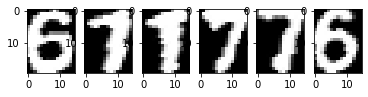

In [116]:
fig_chars = plt.figure()
number_images = []

for c in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[c])
    crop = np.zeros(filtered.shape, dtype=np.uint8)
    cv2.drawContours(crop, contours, c, 255, -1)
    crop = cv2.bitwise_and(crop, filtered)
    crop = crop[y:y+h, x:x+w]

    crop = cv2.resize(crop, (SZ_W, SZ_H), interpolation = cv2.INTER_CUBIC)
    skewed = deskew(crop)
    fig_chars.add_subplot(1, 6, c+1)
    plt.imshow(skewed, cmap = 'gray')
    number_images.append( skewed.flatten().tolist() )

## Classifying the numbers

In [117]:
# Loading the mlp model
mlp = load('../models/mlp.save')

/home/vinihcampos/miniconda3/envs/captcha/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/vinihcampos/miniconda3/envs/captcha/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [118]:
nfce_code = '24170813064901000199650010000038481801014103'
mlp_result = mlp.predict(number_images)
mlp_result = ''.join( [str(x) for x in mlp_result] )
print(mlp_result)

611776


## Finish the pipeline


In [119]:
access_key = driver.find_element_by_id('ctl03_txt_chave_acesso')
captcha_key = driver.find_element_by_id('txt_cod_antirobo')
button = driver.find_element_by_id('btn_consulta_resumida')

In [120]:
access_key.send_keys(nfce_code)
captcha_key.send_keys(mlp_result)
button.click()